In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.callbacks import ModelCheckpoint

In [36]:
df = pd.read_csv("RSCCASN.csv")
df

,DATE,RSCCASN
0,1992-01-01,6938.0
1,1992-02-01,7524.0
2,1992-03-01,8475.0
3,1992-04-01,9401.0
4,1992-05-01,9558.0
...,...,...
381,2023-10-01,24438.0
382,2023-11-01,29150.0
383,2023-12-01,41187.0
384,2024-01-01,19420.0


In [37]:
# Filter the years until the Covid pandemic
df = df.iloc[0:338]

In [38]:
df = df.drop("DATE", axis=1)
target_col = "RSCCASN"

In [39]:
scaler = MinMaxScaler()
df[[target_col]] = scaler.fit_transform(df[[target_col]])
df.index = df.index * 0.1 + 1

In [40]:
# let's figure out a proper cutoff point
# for train/test-split
cutoff = int(len(df) * 0.80)

X_train = df.index[0:cutoff]
y_train = df[target_col].iloc[0:cutoff]

# test data
X_test = df.index[cutoff:]
y_test = df[target_col].iloc[cutoff:]

# convert to NumPy array-format (expected by the generators)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

n_features = 1

# Note to self: is this necessary?
train_series = y_train.reshape((len(y_train), n_features))
test_series = y_test.reshape((len(y_test), n_features))

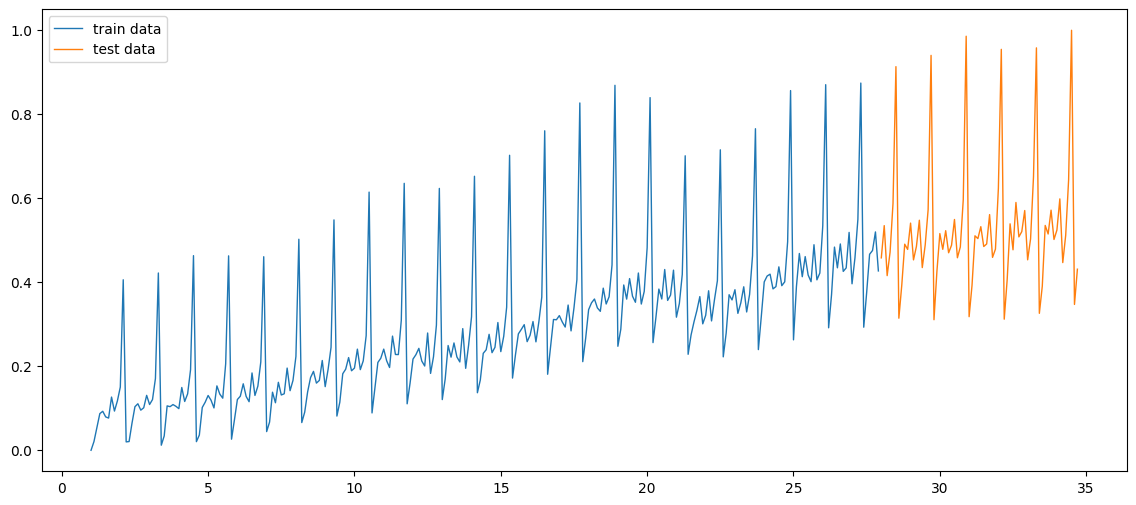

In [41]:
# plot the original train + test data
# see the cutoff point
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.plot(X_train,y_train, lw=1, label='train data')
ax.plot(X_test, y_test,  lw=1, label='test data')
ax.legend(loc="upper left")
plt.show()

In [42]:
# TimeseriesGenerators, for train and test
from keras.preprocessing.sequence import TimeseriesGenerator

# this is the timestep size
# so if we have 1000 points, and look_back is 20 => 50 time steps
look_back  = 12

# using 1 => using time steps
# anything above 1 => windowing (instead of time steps)
window_size = 1

# the amount of data fed into the neural network while training
# the bigger it is, the faster the training
# but with forecasts it also affects the performance
batch_size = 1

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      #sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      #sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

In [43]:
from keras.models import Sequential
from keras.layers import Dense

# rule of thumb: RNN is usually good with short-term trends
# while LSTM is usually good with long-term trends
# effectiveness depends on the situation/dataset
from keras.layers import LSTM
from keras.layers import SimpleRNN

# make a simple LSTM/RNN network
# number of neurons can be adjusted
model = Sequential()

# Simple one layer LSTM/RNN
model.add(LSTM(64, activation="relu", input_shape=(look_back, n_features)))
#model.add(SimpleRNN(32, activation="relu",input_shape=(look_back, n_features)))

# Example for how to use multiple layers to the neural network
# Remember to use return_sequences when passing from an LSTM-layer
# NOTE: Never have return_sequences in the last LSTM-layer!
# If desired, regularisation can be implemented with Dropout layers
#model.add(LSTM(64, activation="relu", input_shape=(look_back, n_features), return_sequences=True))
#model.add(LSTM(16, activation="relu")),

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

callbacks = [
    ModelCheckpoint("best_model_sales.keras", monitor='val_loss', mode='min', save_best_only=True)
]

# start training the model, use also validation data for metrics later
model.fit(train_generator,epochs=150, callbacks=callbacks, verbose=1, validation_data=test_generator)

Epoch 1/150
258/258 [==============================] - 3s 6ms/step - loss: 0.0212 - val_loss: 0.0249
Epoch 2/150
258/258 [==============================] - 1s 5ms/step - loss: 0.0170 - val_loss: 0.0283
Epoch 3/150
258/258 [==============================] - 1s 5ms/step - loss: 0.0162 - val_loss: 0.0157
Epoch 4/150
258/258 [==============================] - 1s 4ms/step - loss: 0.0108 - val_loss: 0.0159
Epoch 5/150
258/258 [==============================] - 1s 5ms/step - loss: 0.0055 - val_loss: 0.0035
Epoch 6/150
258/258 [==============================] - 1s 5ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 7/150
258/258 [==============================] - 1s 5ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 8/150
258/258 [==============================] - 1s 5ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 9/150
258/258 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 7.9321e-04
Epoch 10/150
258/258 [==============================] - 1s 5ms/step - loss: 0.0018 - va

<Axes: >

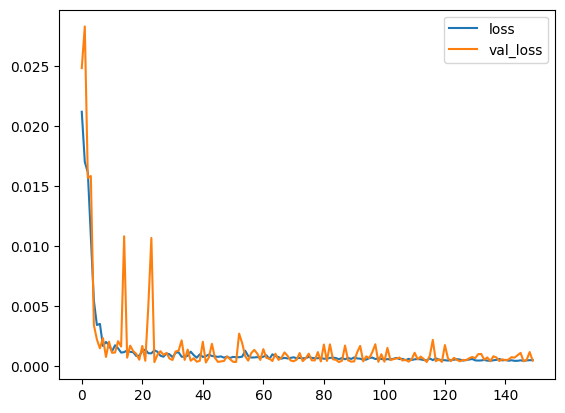

In [44]:
# training metrics
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [45]:
# load the best model from the model checkpoint
model = keras.models.load_model("best_model_sales.keras")

In [46]:
# Create test predictions
test_predictions  = model.predict(test_generator)

56/56 [==============================] - 0s 3ms/step


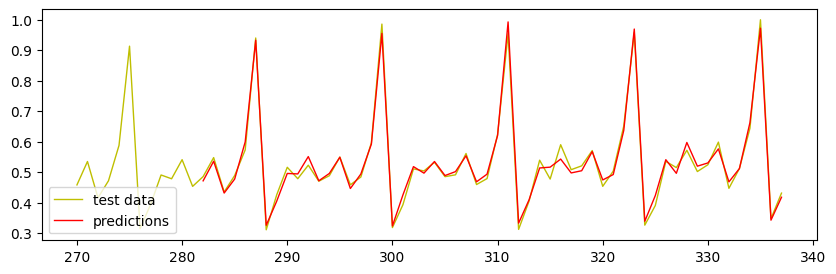

In [47]:
# this code is not optimal
# our code should instead scale based on the X_train / X_test
x1 = np.arange(0,len(y_train))
x2 = np.arange(len(y_train),len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(y_test))

fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# we can also hide the trianing data to inspect the 
# predictions vs. test data separately
#ax.plot(x1,y_train, lw=1, label='train data')
ax.plot(x2,y_test, lw=1, c='y', label='test data')
ax.plot(x3,test_predictions, lw=1, c='r', label='predictions')
ax.legend(loc="lower left")
plt.show()

In [48]:
 # TF evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# these values are very close
# which means our model is quite optimal (on paper!)

258/258 [==============================] - 1s 2ms/step - loss: 5.6927e-04
Training loss: 0.000569273135624826
56/56 [==============================] - 0s 2ms/step - loss: 3.3384e-04
Testing loss: 0.0003338369424454868


In [49]:
# make a separate copy of the test values
# that matches with y_test
actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = np.mean(errors / actual_y_test) * 100

# print out MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# the typical error metrics
# MAE - Mean average error
# MAPE score => less than 10% => excellent result
# MAPE score => 10-20 % => good result
# MAPE score => 20-50% => okay / reasonable / decent result
# negative MAPE score => the model constantly overestimates the values
# MAPE score over 100% => the model constantly underestimates the values
# it's possible to get a weird MAPE result with synthetic test data
# because the data is so predicatble
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test , test_predictions), 2), " units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), " units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test , test_predictions)), 2), " units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test , test_predictions), 2))

MAPE (mean average precision error):
2.9 %

MAE
0.01  units

MSE
0.0  units^2

RMSE:
0.02  units

R-squared:
0.99


In [50]:
# EXTRAPOLATION TEST 
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

# extrapolate the next n values
n = 140
for i in range(n):
    predicted_value = model.predict(current_batch)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

1/1 [==============================] - 0s 25ms/step


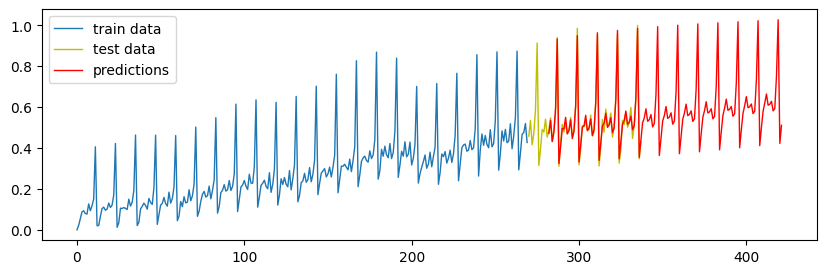

In [51]:
# Plotting the train/test data and overlaying the extrapolated data
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# we can also hide the training data to inspect the
# the predictions vs. test data separately
ax.plot(x1, y_train, lw=1, label='train data')
ax.plot(x2, y_test, lw=1, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
ax.legend(loc="upper left")
plt.show()